###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018  by D. Koehn, T. Meier, R. Hartmann and C. Huebscher, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = 'style/custom.css'
HTML(open(css_file, "r").read())

# AKF einer seismischen Spur

Als elementares, geophysikalisches Anwendungsbeispiel der Autokovarianzfunktion betrachten wir die AKF einer seismischen Spur mit bzw. ohne Ghost und diskutieren deren Eigenschaften im Frequenzbereich. 

## AKF einer seismischen Spur

Sei 

$s_{i}=w_{i}\ast r_{i}=\sum\limits_{k}w_{k}\cdot r_{i-k}$ 

eine seismische Spur bestehend aus dem deterministischen Wavelet $w_{i}$ und der Reflektivität $r_{i}$. Die Reflektivität $\{r_{i}\}$ ist ein [iid](https://de.wikipedia.org/wiki/Unabh%C3%A4ngig_und_identisch_verteilte_Zufallsvariablen)-Zufallsprozess, sodass analog zu dem [Beispiel der AKV eines Zufallsprozesses](https://nbviewer.jupyter.org/github/daniel-koehn/Geophysikalische-Signalverarbeitung/blob/master/3_Korrelation_AKF_Beispiele.ipynb)  für ihre Autokovarianz gilt: 

$\rho_{r,r}(i)=\sigma_{r}^{2}\delta(i)$. 

Dann ist die Autokovarianz der seismischen Spur:

\begin{equation}
\begin{split}
\rho_{s,s}(i)&=E[s_{j}\cdot s_{j+i}]\\
&=E\left[\sum\limits_{k}w_{k}r_{j-k}\cdot\sum\limits_{l}w_{l}r_{(j+i)-l}\right]\\
&=\sum\limits_{k,l}w_{k}w_{l}E[r_{j-k}\cdot r_{j+i-l}]\\
&=\begin{cases}
\sum\limits_{k,l}w_{k}w_{l}\sigma_{r}^{2}&:j-k=j+i-l\Leftrightarrow l=k+i\\
0&:\text{ sonst}
\end{cases}\\
&=\sigma_{r}^{2}\sum\limits_{k}w_{k}w_{k+i}\\
&=\sigma_{r}^{2}\cdot\rho_{w,w}(i)
\end{split}
\notag
\end{equation}

Die Autokovarianz der Seismischen Spur ist proportional zur AKF des Wavelets: $\rho_{s,s}(i)\propto\rho_{w,w}(i)$.

Für die Spektren gilt demnach:

\begin{align}
\mathfrak{F}\{\rho_{s,s}(i)\}&=\sigma _{r}^{2}\cdot\mathfrak{F}\{\rho_{w,w}(i)\}\notag\\ \notag
|S(\omega)|^{2}&=\sigma _{r}^{2}\cdot|W(\omega)|^{2}
\end{align}

Das Powerspekrtum der Seismischen Spur ist proportional zum Powerspektrum des Wavelets. So kann der Frequenzgehalt des initialen Wavelets aus der AKF der seismischen Spur abgelesen werden. Die AKF der Spur liefert also Informationen über das Amplitudenspektrum des Wavelets nicht über über sein Phasenspektrum.

Macht man zusätzliche Annahmen über das Phasenspektrum (z.B., dass es minimalphasig ist,) kann das Wavelet anhand der AKF berechnet werden und eine Dekonvolution der Spur durchgeführt werden (Vergleiche Abschnitt Faltung).

### AKF einer seismischen Spur 
### (marine Akquisitionsgeometrie)

Als Beispiel betrachten wir eine Spur, die im Rahmen eines marinen seismischen Surveys am Skagerrak mit einem 680 m langem Streamer gemessen wurde. Die betreffende seismische Spur befindet sich bei einem Offset von 385 m:

In [2]:
# Importiere Python Bibliotheken 
# ------------------------------
import numpy                      # Bibliothek NumPy
from scipy import signal          # Bibliothek SciPy
from gsv.gsv_func import *        # Bibliothek "Geophysikalische Signalverarbeitung"

In [6]:
# Importiere seismische Spur 72 von Schuss 374 des Skagerrak Datensatzes
tmp = np.loadtxt('data/skagerrak/skagerrak_streamer_trace_ntr-half_shot_374.dat', delimiter='\t', skiprows=0, unpack='False')

# Das erste Sample bezeichnet das Sampleintervall ...
dt = tmp[0]

# ... die restlichen Samples die seismische Spur
trace_skagerrak = tmp[1:-1]

# Definiere Zeit-Vektor
nt = (int)(len(trace_skagerrak))
time = np.arange(0,nt*dt,dt)

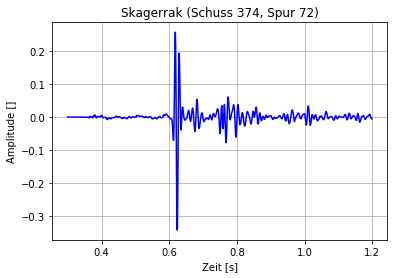

In [7]:
# Plotte Ausschnitt der Skagerrak Spur
nt_start = (int)(0.3/dt)
nt_end = (int)(1.2/dt)

draw_func1(time[nt_start:nt_end],trace_skagerrak[nt_start:nt_end],'Skagerrak (Schuss 374, Spur 72)', 'Zeit [s]', 'Amplitude []')

Das Beispielseismogramm zeigt einen deutlichen Ersteinsatz, sowie mehrere (multiple) Reflexionen. Betrachten wir die AKF,

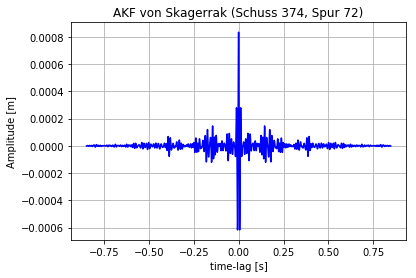

In [8]:
# AKF der Skagerrak Spur
AKF_skagerrak = np.correlate(trace_skagerrak, trace_skagerrak, mode='same')

# Multipliziere AKF_skagerrak mit dt um korrekte Amplituden zu erhalten
AKF_skagerrak = AKF_skagerrak * dt

# Berechne time-lags
nt = (int)(len(time))
lags = np.arange(-nt/2,nt/2,1) * dt # time-lags

# Plotte AKF der Skagerrak Spur
draw_func1(lags,AKF_skagerrak,'AKF von Skagerrak (Schuss 374, Spur 72)', 'time-lag [s]', 'Amplitude [m]')

so fällt wie theoretisch vorhergesagt der deutliche $\delta$-Impuls bei einem time-lag von 0 s auf. Allerdings finden sich weitere Maxima der AKF bei von Null verschiedenen time-lags. Diese entstehen durch den Ghost, sowie multiple Reflexionen. Betrachten wir im folgenden den Einfluß des Ghosts etwas genauer.

## AKF einer seismischen Spur mit Ghost

Sei $y_k=s_k\ast g_k$ eine seismische Spur mit Ghost, wobei $s_k$ die reine seismische Spur wie oben definiert und $g_k$ der Ghostoperator der Reflexion ist. Dann ist 

$Y(\omega)=S(\omega)\cdot G(\omega)$ 

das Spektrum der Spur mit Ghost und es gilt für die Fouriertransformierte der AKF der Spur:

\begin{equation}
\begin{split}
\mathfrak{F}\{\rho_{y,y}(k)\}&=Y^{\ast}(\omega) Y(\omega)\\&=S^{\ast}(\omega)G^{\ast}(\omega)S(\omega)G(\omega)\\
&=S^{\ast}(\omega)S(\omega)G^{\ast}(\omega)G(\omega)\\
&=\mathfrak{F}\{\rho_{s,s}(k)\}\cdot\mathfrak{F}\{\rho_{g,g}(k)\}
\end{split}
\notag
\end{equation}

Daraus folgt für die AKF im Zeitbereich:

\begin{equation}
\rho_{y,y}(k)=\rho_{s,s}(k)\ast\rho_{g,g}(k)
=\sigma_{r}^{2}\cdot\rho_{w,w}(k)\ast\rho_{g,g}(k)
\notag
\end{equation}

Der Ghost kann anhand der AKF der Spur erkannt werden. Die AKF des Ghostoperators wird mit der AKF der Spur gefaltet, so dass die AKF der Spur ohne Ghost einmal ohne Zeitverschiebung und zweimal symmetrisch zeitverschoben bei $\pm n \Delta t$ auftritt. Dadurch kann die Zeitverschiebung zwischen Spur ohne Ghost und mit Ghost $n\Delta t$ anhand der maximalen Amplitude der verschobenen AKFs abgelesen werden.

Im Fall des Skagerrak-Beispiels liegt die Zeitverschiebung des Ghosts bei ca. 0.05 s. 